In [2]:
import copy
import glob
import os
import time
from pathlib import Path
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from data_process import (add_noise, create_data, flip, greyscale,
                          normalization, rotate, process)



In [ ]:


train_path = 'dataset/training_data_aug'
test_path = 'dataset/testing_data'

# create dataset
df_train = process(train_path)
df_test = process(test_path)

# add augmented train data


# define parameters
EPOCHS = 10
BATCH_SIZE = 32
RANDOM_SEED = 42
thres_acc = 0.75

# generating images
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_image = train_generator.flow_from_dataframe(dataframe=df_train,
                                                  x_col='filepaths',
                                                  y_col='labels',
                                                  target_size=(224, 224),
                                                  batch_size=BATCH_SIZE,
                                                  subset='training',
                                                  random_seed=RANDOM_SEED)

test_image = test_generator.flow_from_dataframe(dataframe=df_test,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=(224, 224),
                                                batch_size=BATCH_SIZE,
                                                random_seed=RANDOM_SEED
                                                )

pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrained_model.trainable = False  # We don't want to train again the resnet

inputs = pretrained_model.input

x = Dense(120, activation='relu')(pretrained_model.output)
x = Dense(120, activation='relu')(x)  # adding some custom layers of our coice
x = Dense(120, activation='relu')(x)

outputs = Dense(2, activation='sigmoid')(x)
# output choice
model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mo_fit = model.fit(train_image, epochs=EPOCHS)

train_acc = mo_fit.history



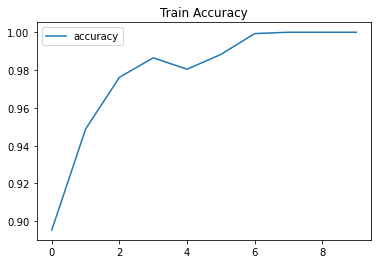

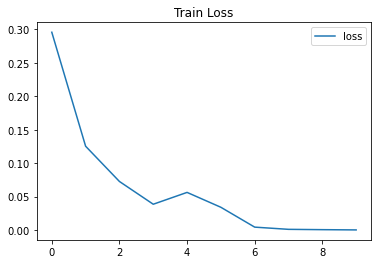

In [3]:

pd.DataFrame(mo_fit.history)[['accuracy']].plot()
plt.title("Train Accuracy")
plt.show()


pd.DataFrame(mo_fit.history)[['loss']].plot()
plt.title("Train Loss")
plt.show()




In [86]:

print('Test Accuracy')
eval_result = model.evaluate(test_image)


Test Accuracy
11/11 [==============================] - 40s 3s/step - loss: 0.8418 - accuracy: 0.8554


In [102]:
#modelPath = "resnet_aug\cv_image_resnet_84.pt"
modelPath = "resnetV2_aug\cv_image_resnetV2_57.pt"

model = keras.models.load_model(modelPath)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
EPOCHS = 10
BATCH_SIZE = 32
RANDOM_SEED = 42

test_path2 = 'dataset/unknown_data'
df_test2 = process(test_path2)
test_generator2 = ImageDataGenerator(preprocessing_function=preprocess_input)
test_image2 = test_generator2.flow_from_dataframe(dataframe=df_test2,
                                                x_col='filepaths',
                                                y_col=None,
                                                target_size=(224, 224),
                                                batch_size=1,
                                                class_mode=None,
                                                random_seed=RANDOM_SEED
                                                )

Found 9 validated image filenames.


In [103]:
pred_result2= model.predict(test_image2)

In [104]:
pred_result2

array([[1.0000000e+00, 1.0000000e+00],
       [3.2258034e-04, 2.3102760e-04],
       [9.7843707e-01, 5.5510868e-10],
       [2.9399117e-17, 1.0000000e+00],
       [1.0000000e+00, 1.4332266e-11],
       [1.0000000e+00, 7.5289641e-10],
       [9.2424642e-07, 1.0000000e+00],
       [1.0000000e+00, 1.0000000e+00],
       [9.8301643e-01, 1.0000000e+00]], dtype=float32)

In [105]:
pred_class=np.argmax(pred_result2,axis=1)
pred_class

array([0, 0, 0, 1, 0, 0, 1, 0, 1], dtype=int64)

In [14]:
test_image2[0][0].shape

(224, 224, 3)

In [100]:
Labels = {0:'cracked', 1:'normal'}

In [94]:
i=6
img2 = test_image2[i][0]
#img2 = np.uint8(img2)
#img2 = ImageDataGenerator(rescale=1./255.)


In [89]:
#np.clip(img2,255,520,out=img2)
#img2 = img2.astype('uint8')
img2 = cv.normalize(src=img2, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

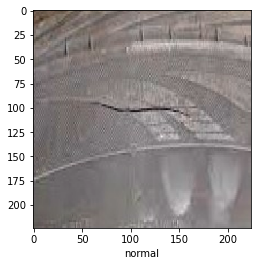

In [90]:
plt.imshow(img2)
plt.xlabel(Labels[pred_class[i]])
plt.show()
#cv_64f to cv_u8

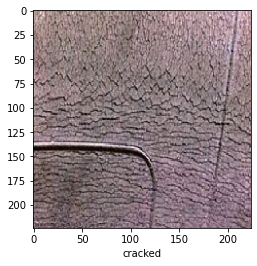

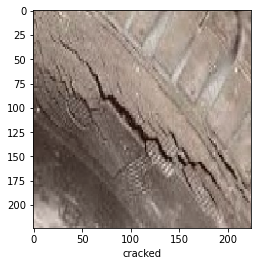

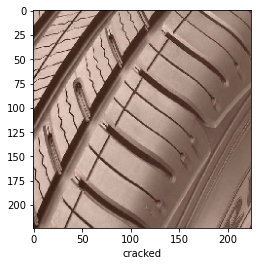

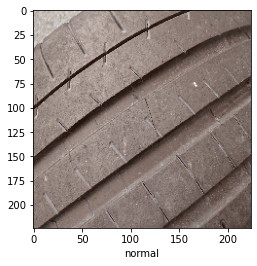

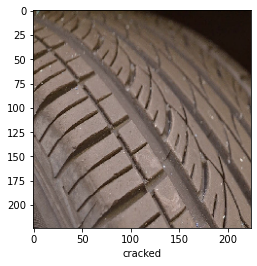

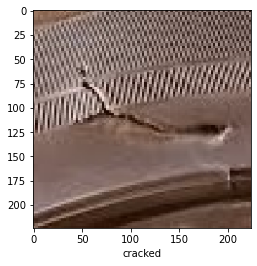

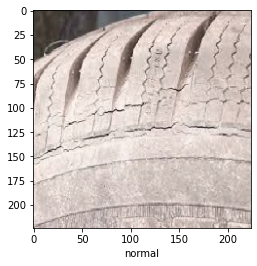

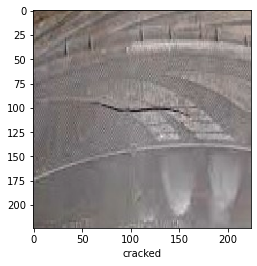

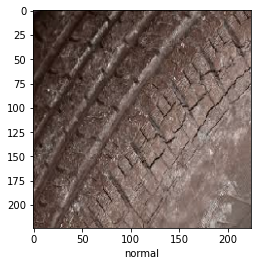

In [106]:
for i in range(len(test_image2)):
    img3 = test_image2[i][0]
    img3 = cv.normalize(src=img3, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
    
    plt.imshow(img3)
    plt.xlabel(Labels[pred_class[i]])
    plt.show()

img = cv.imread('dataset/unknown_data/unknown/images_2.jpg')
img = cv.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])
eval_result3 = model.predict(img)

In [50]:
eval_result3[0][1]

1.0

In [52]:
#test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

NameError: name 'STEP_SIZE_TEST' is not defined

In [ ]:


savedFile = f'resnet_aug/cv_image_resnet_{(eval_result[1]*100):.0f}.pt'
model.save(savedFile)
print("Export Path = "+savedFile)

